In [ ]:
using DIVAnd,CairoMakie

include("../src/batchStagYY.jl")

: 

In [2]:
dir="/Users/nobuaki/Documents/MantleConvectionTakashi/data2025"


"/Users/nobuaki/Documents/MantleConvectionTakashi/data2025"

In [3]:
compositionFiles=myListDir(dir; pattern=r"test_c\d");
temperatureFiles=myListDir(dir; pattern=r"test_t\d");

In [4]:
newFieldOneArray=nothing
boolFlat = true
rC=nothing
Xnode=[]
Ynode=[]
Znode=[]

rawField=nothing

for file in temperatureFiles[50:50]
    @show file
    @show magic, inputILEN, byte_reverse_in, io=read_magic(file)
    @show magic,nval = evaluate_nval_from_magicNumber(magic)
    @show intDataType,floatDataType,dx,dy,nx,ny,nz,nb,nnx,nny,nnz,nnb,rcmb,iStep,time,zc,boolSpherical=read_header(io,inputILEN,magic)
   
    nodes=nothing


   
    if nx == 1
       boolFlat = true
    end
 


    if boolSpherical
        # these are the grid points including the boundaries
        r = rcmb .+ zc[1,1:nz+1]
        
        theta = (collect(1:1:nx+1) .- (nx+1)) .* dx .+ 0.5*π
        phi = (collect(1:1:ny+1) .- (ny+1)) .* dy
        

        # these are the midpoints 
        r_mid = rcmb .+ zc[2,1:nz]
        theta_mid = (collect(1:1:nx) .- (nx+1)) .* dx .+ 0.5*π .+ 0.5*dx
        phi_mid = phi = (collect(1:1:ny) .- (ny+1)) .* dy .+ 0.5*dy
        
        # interpolation should be done with the midpoints + end points

        r_new = prepend!(r_mid,r[1])
        r_new = push!(r_mid,r[end])
        minR = r[1]
        maxR = r[end]
        rC=r_new

        theta_new = prepend!(theta_mid,theta[1])
        theta_new = push!(theta_new,theta[end])
        minθ = theta[1]
        maxθ = theta[end]
        phi_new = prepend!(phi_mid,phi[1])
        phi_new = push!(phi_new,phi[end])
        minϕ = phi[1]
        maxϕ = phi[end]
        if boolFlat
            minθ = 0.
            maxθ = 0.
            theta_new = (π/2)  # if flat, we are looking at the 
            nodes=(theta_new,phi_new,r_new)
        else   
            nodes=(theta_new,phi_new,r_new)
        end

    
    else
        # do not know if this works (certainly not! try to mimic the code above for the spherical case)
        x=collect(1:1:nx+1) .* dx
        y=collect(1:1:ny+1) .* dy
        z=zc
        nodes=(x,y,z)
    end

    

    theta_new_piCoef = theta_new ./ π
    phi_new_piCoef = phi_new ./ π

    if boolSpherical
        for rTemp in r_new
            for phiTemp in phi_new_piCoef
                cosPhiPi = cospi(phiTemp)
                sinPhiPi = sinpi(phiTemp)
               
                for thetaTemp in theta_new_piCoef
                    cosThetaPi = cospi(thetaTemp)
                    sinThetaPi = sinpi(thetaTemp) 
                    Xnode = push!(Xnode,rTemp*sinThetaPi*cosPhiPi)
                    Ynode = push!(Ynode,rTemp*sinThetaPi*sinPhiPi)
                    Znode = push!(Znode,rTemp*cosThetaPi)

                end
            end
        end
    else
        @error "cartesian format: not yet developed"
    end

    


   #coord[1,ix,iy,iz] = r[iz]*sin(theta)*cos(phi)
   #coord[2,ix,iy,iz] = r[iz]*sin(theta)*sin(phi)
   #coord[3,ix,iy,iz] = r[iz]*cos(theta)
   
   
   

   #field = binRead(io,floatDataType,(nx)*(ny)*(nz))
   #field = binRead(io,Float64,nx*ny*nz)
   #rawField =field
   #newField = nothing

   rawField = readField(io,floatDataType,nval,nx,ny,nz,nb,nnx,nny,nnz,nnb)

   
    if boolFlat
        #field=reshape(field, (ny,nz)) 

        field = zeros(floatDataType,ny,nz)
        field[1:ny,1:nz]=rawField[1,1,1:ny,1:nz,1]


        newField = zeros(floatDataType,ny+2,nz+2)

        # the interior

        newField[2:ny+1,2:nz+1] = field[1:end,1:end]

        # 4 'surfaces'

        newField[1,2:nz+1] = field[1,1:nz]
        newField[end,2:nz+1] = field[end,1:nz]
        newField[2:ny+1,1] = field[1:ny,1]
        newField[2:ny+1,end] = field[1:ny,end]

        # 4 'endpoints'

        newField[1,1,1]=field[1,1,1]
        newField[1,end,1]=field[1,end,1]
        newField[1,1,end]=field[1,1,end]
        newField[1,end,end]=field[1,end,end]


    else
        #field=reshape(field, (nx,ny,nz)) 
        field = zeros(floatDataType,nx,ny,nz)
        field[1:ny,1:nz]=rawField[1,1:nx,1:ny,1:nz,1]

        newField = zeros(floatDataType,nx+2,ny+2,nz+2)

        # the interior

        newField[2:nx+1,2:ny+1,2:nz+1] = field[1:nx,1:ny,1:nz]

        # 6 'surfaces'
        
        newField[1,2:ny+1,2:nz+1] = field[1,1:ny,1:nz]
        newField[end,2:ny+1,2:nz+1] = field[end,1:ny,1:nz]
        newField[2:nx+1,1,2:nz+1] = field[1:nx,1,1:nz]
        newField[2:nx+1,end,2:nz+1] = field[1:nx,end,1:nz]
        newField[2:nx+1,2:ny+1,1] = field[1:nx,1:ny,1]
        newField[2:nx+1,2:ny+1,end] = field[1:nx,1:ny,end]

        # 8 'endpoints'
        newField[1,1,1]=field[1,1,1]
        newField[end,1,1]=field[end,1,1]
        newField[1,end,1]=field[1,end,1]
        newField[end,end,1]=field[end,end,1]
        newField[1,1,end]=field[1,1,end]
        newField[end,1,end]=field[end,1,end]
        newField[1,end,end]=field[1,end,end]
        newField[end,end,end]=field[end,end,end]

    end

    if boolFlat
        newField=reshape(newField,(ny+2)*(nz+2))
    else
        newField=reshape(newField,(nx+2)*(ny+2)*(nz+2))
    end
   #fieldInterpolated=interpolate(nodes,newField,Gridded(Linear()))



   newFieldOneArray=newField
end


#X=collect(-6500e3:500e3:6500e3)
#Y=collect(-6500e3:500e3:6500e3)
#Z=collect(-6500e3:500e3:6500e3)

minX = -6500e3
maxX = 6500e3
nX = 131

minY = -6500e3
maxY = 6500e3
nY = 131

minZ = -6500e3
maxZ = 6500e3
nZ = 131

#X=collect(0:200e6:6500e6)
#Y=collect(0:200e6:6500e6)
#Z=collect(0:200e6:6500e6)







file = "/Users/nobuaki/Documents/MantleConvectionTakashi/data2025/test_t00049"
magic = binRead(io, Int32) = 8009
(magic, inputILEN, byte_reverse_in, io) = read_magic(file) = (9, 8, false, IOStream(<file /Users/nobuaki/Documents/MantleConvectionTakashi/data2025/test_t00049>))
(magic, nval) = evaluate_nval_from_magicNumber(magic) = (9, 1)
inputILEN = 8
(nnx, nny, nnz) = binRead(io, intDataType, 3) = Any[1, 4, 1]
rcmb = binRead(io, floatDataType) = 3.486e6
iStep = binRead(io, intDataType) = 24500
time = binRead(io, floatDataType) = 5.013410654849366e16
(intDataType, floatDataType, dx, dy, nx, ny, nz, nb, nnx, nny, nnz, nnb, rcmb, iStep, time, zc, boolSpherical) = read_header(io, inputILEN, magic) = (Int64, Float64, 0.0061359375, 0.0061359375, 1, 256, 128, 1, 1, 4, 1, 1, 3.486e6, 24500, 5.013410654849366e16, Any[0.0 13713.674545288086 28046.751022338867 43019.490242004395 58657.941818237305 74970.78895568848 91981.18686676025 109692.02995300293 128100.42381286621 147209.2628479004 167001.1

131

In [5]:
rθmap=reshape(newFieldOneArray,258,130)

258×130 Matrix{Float64}:
 3991.31  3991.31  3968.95  3936.74  …  300.0  300.0  300.0  300.0  300.0
 3991.31  3991.31  3968.95  3936.74     300.0  300.0  300.0  300.0  300.0
 3989.66  3989.66  3963.68  3926.85     300.0  300.0  300.0  300.0  300.0
 3987.7   3987.7   3957.3   3914.06     300.0  300.0  300.0  300.0  300.0
 3985.11  3985.11  3948.63  3897.0      300.0  300.0  300.0  300.0  300.0
 3981.67  3981.67  3937.63  3876.8   …  300.0  300.0  300.0  300.0  300.0
 3978.3   3978.3   3926.46  3856.83     300.0  300.0  300.0  300.0  300.0
 3974.2   3974.2   3913.29  3835.96     300.0  300.0  300.0  300.0  300.0
 3970.04  3970.04  3900.3   3815.83     300.0  300.0  300.0  300.0  300.0
 3965.33  3965.33  3887.17  3796.97     300.0  300.0  300.0  300.0  300.0
    ⋮                                ⋱    ⋮                         
 3985.9   3985.9   3956.96  3931.74     300.0  300.0  300.0  300.0  300.0
 3988.27  3988.27  3963.84  3942.16  …  300.0  300.0  300.0  300.0  300.0
 3990.49  3990.49 

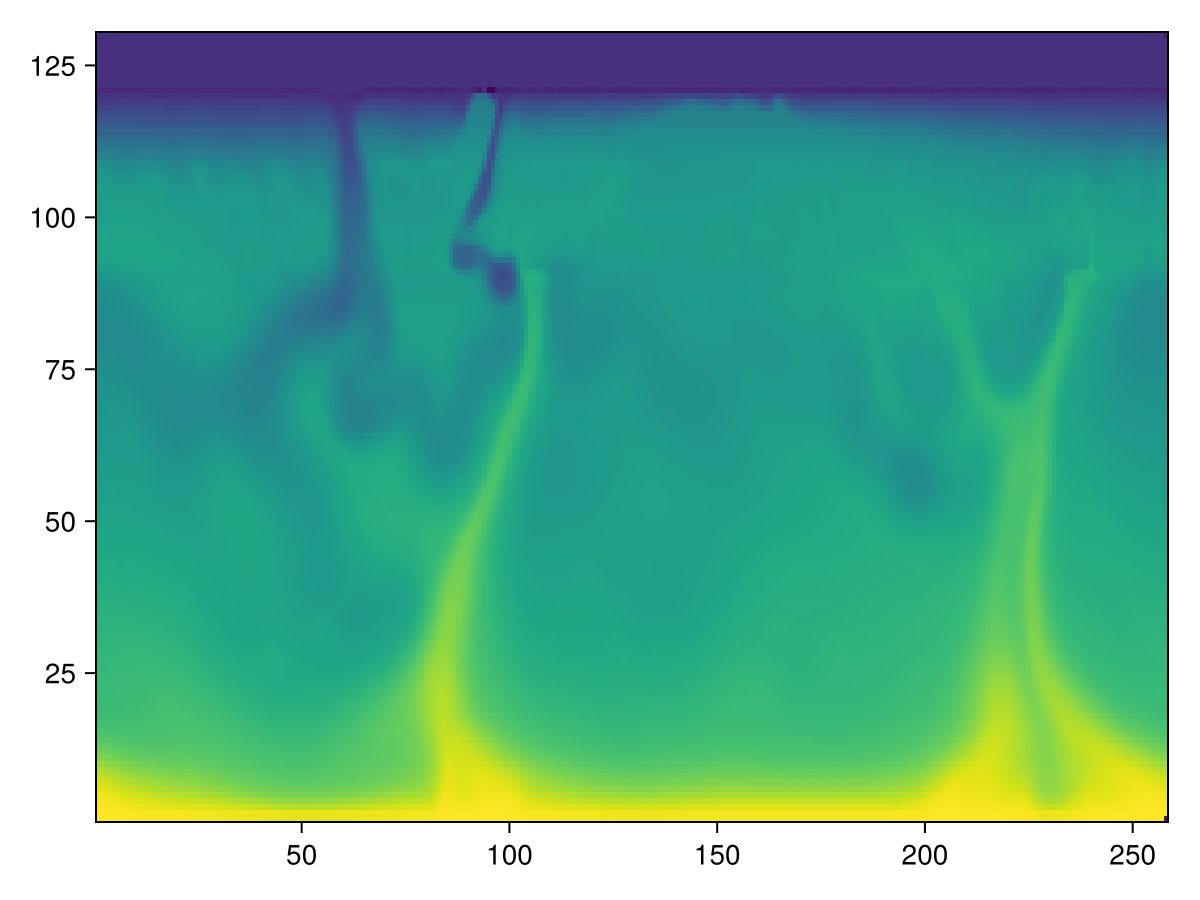

In [6]:
heatmap(rθmap)

In [11]:
minX = -6500e3
maxX = 6500e3
#nX = 131
nX = 1301

minY = -6500e3
maxY = 6500e3
#nY = 131
nY = 1301

minZ = -6500e3
maxZ = 6500e3
#nZ = 131
nZ = 1301

if boolFlat
    nZ=1
    minZ=0.0
    maxZ=0.0
    mask,(pm,pn),(xi,yi) = DIVAnd_rectdom(range(minX,stop=maxX,length=nX),
                                            range(minY,stop=maxY,length=nY));
else

    mask,(pm,pn,po),(xi,yi,zi) = DIVAnd_rectdom(range(minX,stop=maxX,length=nX),
                                            range(minY,stop=maxY,length=nY),
                                            range(minZ,stop=maxZ,length=nZ));
end

(Bool[1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], ([0.0001 0.0001 … 0.0001 0.0001; 0.0001 0.0001 … 0.0001 0.0001; … ; 0.0001 0.0001 … 0.0001 0.0001; 0.0001 0.0001 … 0.0001 0.0001], [0.0001 0.0001 … 0.0001 0.0001; 0.0001 0.0001 … 0.0001 0.0001; … ; 0.0001 0.0001 … 0.0001 0.0001; 0.0001 0.0001 … 0.0001 0.0001]), ([-6.5e6 -6.5e6 … -6.5e6 -6.5e6; -6.49e6 -6.49e6 … -6.49e6 -6.49e6; … ; 6.49e6 6.49e6 … 6.49e6 6.49e6; 6.5e6 6.5e6 … 6.5e6 6.5e6], [-6.5e6 -6.49e6 … 6.49e6 6.5e6; -6.5e6 -6.49e6 … 6.49e6 6.5e6; … ; -6.5e6 -6.49e6 … 6.49e6 6.5e6; -6.5e6 -6.49e6 … 6.49e6 6.5e6]))

In [46]:
# 2D only

correlationLength=(100e2,100e2)
epsilon2 =1.;
fi,s = DIVAndrun(mask,(pm,pn),(xi,yi),(Xnode,Ynode),newFieldOneArray,correlationLength,epsilon2);

In [ ]:
# 4 times the disk


fi = quarterDiskExtrapolation(fi,nX,nY)


1301×1301 Matrix{Float64}:
 1.08628e-109  1.62514e-109  2.96895e-109  …  1.62514e-109  1.08628e-109
 1.62514e-109  2.43249e-109  4.44645e-109     2.43249e-109  1.62514e-109
 2.96893e-109  4.44644e-109  8.13339e-109     4.44645e-109  2.96895e-109
 5.78062e-109  8.66202e-109  1.58546e-108     8.66206e-109  5.78066e-109
 1.14455e-108  1.71594e-108  3.14267e-108     1.71595e-108  1.14456e-108
 2.27508e-108  3.41255e-108  6.25361e-108  …  3.41258e-108  2.27511e-108
 4.52504e-108  6.79076e-108  1.24515e-107     6.79084e-108  4.5251e-108
 8.99804e-108  1.35101e-107  2.47865e-107     1.35103e-107  8.99819e-108
 1.78847e-107  2.68662e-107  4.93191e-107     2.68666e-107  1.78851e-107
 3.55305e-107  5.33997e-107  9.80847e-107     5.34007e-107  3.55313e-107
 ⋮                                         ⋱                ⋮
 1.78847e-107  2.68662e-107  4.93191e-107     2.68662e-107  1.78847e-107
 8.99804e-108  1.35101e-107  2.47865e-107     1.35101e-107  8.99804e-108
 4.52504e-108  6.79076e-108  1.24515

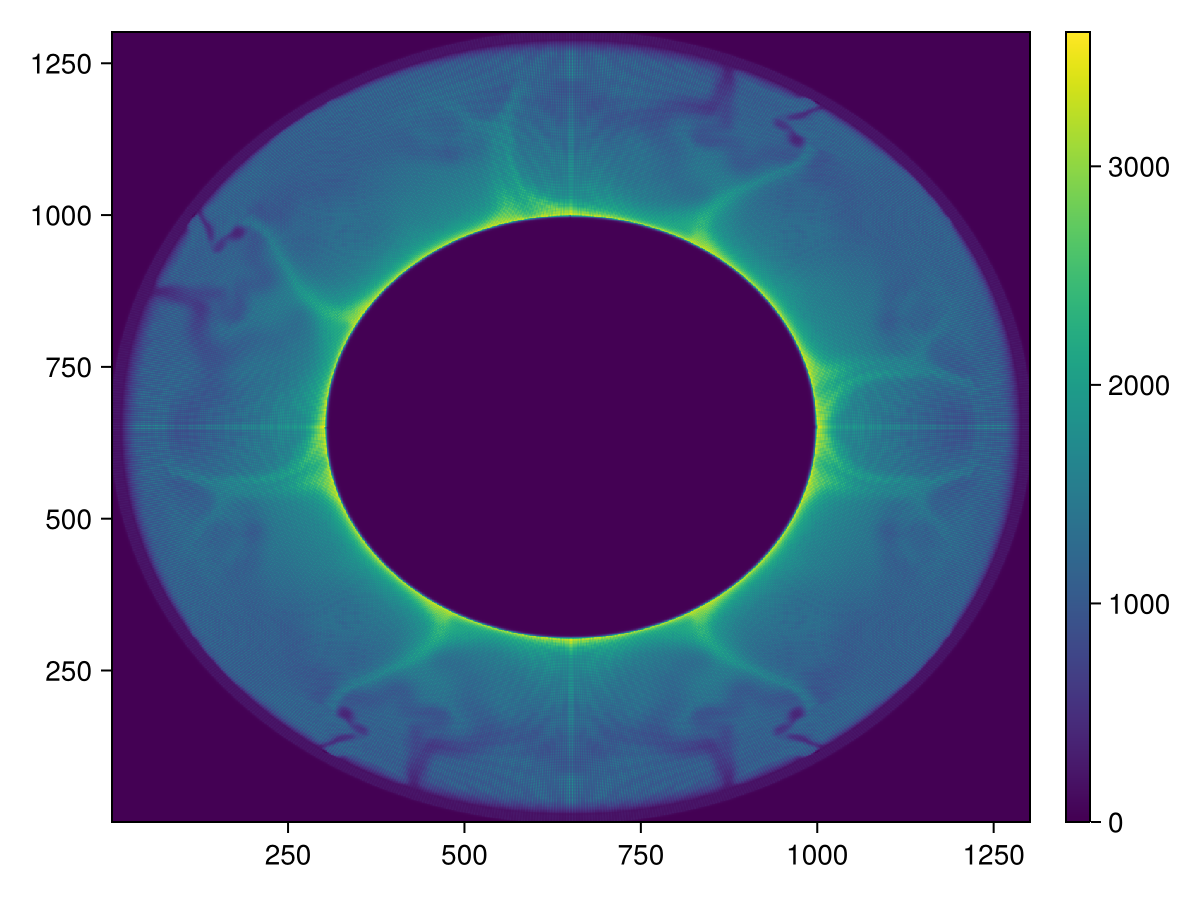

In [48]:
fig = Figure()
ax = Axis(fig[1,1])

hm=heatmap!(ax,fi,colormap=cgrad(:viridis))
Colorbar(fig[:, 2], hm)
fig

In [11]:
maximum(fi)

2600.5348112847078

In [12]:
minimum(fi)

-34.506348981852284

In [14]:
for iz in 1:size(Z,1) 
    z=Z[iz]
    for iy in 1:size(Y,1)
       y=Y[iy]
       for ix in 1:size(X,1)
          x=X[ix]
          r = sqrt(x^2+y^2+z^2)
 
          theta =nothing
 
          if boolFlat
             theta = π/2
          else
             theta = acos(z/r)
          end
 
          if r == 0 
             phi =0
          else            
             #rxy = sqrt(x^2+y^2)
          
 
             if x == 0. && y >= 0
                phi = 0
             elseif x == 0. && y < 0
                phi = -π
             elseif x < 0 && y > 0
                phi = atan(y/x) + π
             elseif x < 0 && y < 0
                phi = atan(y/x) - π
             else
                phi = atan(y/x)
             end
 
             #@show minϕ, maxϕ
             #@show r, theta, phi
             if boolFlat
                if (r-minR)*(r-maxR) <= 0  && (phi-minϕ)*(phi-maxϕ) <= 0
                   count += 1
 
                   fieldCartesian[ix,iy,iz]= Interpolator(phi,r)
                end
             else
                if (r-minR)*(r-maxR) <= 0 && (theta-minθ)*(theta-maxθ) <= 0 && (phi-minϕ)*(phi-maxϕ) <= 0
                #@show r, theta, phi  
                   count += 1
                end
             end
          end   
          
       end
    end
 end

UndefVarError: UndefVarError: `Z` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [16]:


# final grid
testsizexy=2
testsizez=2
testsizet=4
mask,(pm,pn,po,pq),(xi,yi,zi,ti) = DIVAnd_rectdom(range(0,stop=1,length=testsizexy),
                                                  range(0,stop=1,length=testsizexy),
                                                  range(0,stop=1,length=testsizez),
                                                  range(0,stop=1,length=testsizet))

(Bool[1 1; 1 1;;; 1 1; 1 1;;;; 1 1; 1 1;;; 1 1; 1 1;;;; 1 1; 1 1;;; 1 1; 1 1;;;; 1 1; 1 1;;; 1 1; 1 1], ([1.0 1.0; 1.0 1.0;;; 1.0 1.0; 1.0 1.0;;;; 1.0 1.0; 1.0 1.0;;; 1.0 1.0; 1.0 1.0;;;; 1.0 1.0; 1.0 1.0;;; 1.0 1.0; 1.0 1.0;;;; 1.0 1.0; 1.0 1.0;;; 1.0 1.0; 1.0 1.0], [1.0 1.0; 1.0 1.0;;; 1.0 1.0; 1.0 1.0;;;; 1.0 1.0; 1.0 1.0;;; 1.0 1.0; 1.0 1.0;;;; 1.0 1.0; 1.0 1.0;;; 1.0 1.0; 1.0 1.0;;;; 1.0 1.0; 1.0 1.0;;; 1.0 1.0; 1.0 1.0], [1.0 1.0; 1.0 1.0;;; 1.0 1.0; 1.0 1.0;;;; 1.0 1.0; 1.0 1.0;;; 1.0 1.0; 1.0 1.0;;;; 1.0 1.0; 1.0 1.0;;; 1.0 1.0; 1.0 1.0;;;; 1.0 1.0; 1.0 1.0;;; 1.0 1.0; 1.0 1.0], [3.0 3.0; 3.0 3.0;;; 3.0 3.0; 3.0 3.0;;;; 3.0 3.0; 3.0 3.0;;; 3.0 3.0; 3.0 3.0;;;; 2.9999999999999996 2.9999999999999996; 2.9999999999999996 2.9999999999999996;;; 2.9999999999999996 2.9999999999999996; 2.9999999999999996 2.9999999999999996;;;; 2.9999999999999996 2.9999999999999996; 2.9999999999999996 2.9999999999999996;;; 2.9999999999999996 2.9999999999999996; 2.9999999999999996 2.9999999999999996]), ([

In [17]:
pm


2×2×2×4 Array{Float64, 4}:
[:, :, 1, 1] =
 1.0  1.0
 1.0  1.0

[:, :, 2, 1] =
 1.0  1.0
 1.0  1.0

[:, :, 1, 2] =
 1.0  1.0
 1.0  1.0

[:, :, 2, 2] =
 1.0  1.0
 1.0  1.0

[:, :, 1, 3] =
 1.0  1.0
 1.0  1.0

[:, :, 2, 3] =
 1.0  1.0
 1.0  1.0

[:, :, 1, 4] =
 1.0  1.0
 1.0  1.0

[:, :, 2, 4] =
 1.0  1.0
 1.0  1.0

In [18]:
(xi,yi,zi,ti)

([0.0 0.0; 1.0 1.0;;; 0.0 0.0; 1.0 1.0;;;; 0.0 0.0; 1.0 1.0;;; 0.0 0.0; 1.0 1.0;;;; 0.0 0.0; 1.0 1.0;;; 0.0 0.0; 1.0 1.0;;;; 0.0 0.0; 1.0 1.0;;; 0.0 0.0; 1.0 1.0], [0.0 1.0; 0.0 1.0;;; 0.0 1.0; 0.0 1.0;;;; 0.0 1.0; 0.0 1.0;;; 0.0 1.0; 0.0 1.0;;;; 0.0 1.0; 0.0 1.0;;; 0.0 1.0; 0.0 1.0;;;; 0.0 1.0; 0.0 1.0;;; 0.0 1.0; 0.0 1.0], [0.0 0.0; 0.0 0.0;;; 1.0 1.0; 1.0 1.0;;;; 0.0 0.0; 0.0 0.0;;; 1.0 1.0; 1.0 1.0;;;; 0.0 0.0; 0.0 0.0;;; 1.0 1.0; 1.0 1.0;;;; 0.0 0.0; 0.0 0.0;;; 1.0 1.0; 1.0 1.0], [0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0;;;; 0.3333333333333333 0.3333333333333333; 0.3333333333333333 0.3333333333333333;;; 0.3333333333333333 0.3333333333333333; 0.3333333333333333 0.3333333333333333;;;; 0.6666666666666666 0.6666666666666666; 0.6666666666666666 0.6666666666666666;;; 0.6666666666666666 0.6666666666666666; 0.6666666666666666 0.6666666666666666;;;; 1.0 1.0; 1.0 1.0;;; 1.0 1.0; 1.0 1.0])